---
title: Virtual Detector Ptychography Contrast Transfer
authors: [Julie Marie Bekkevold, Georgios Varnavides]
date: 2024-09-30
---

In [1]:
# enable interactive matplotlib
%matplotlib widget 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import ctf # import custom plotting / utils
from tqdm.notebook import tqdm

import ipywidgets
from IPython.display import display

## 4D STEM Simulation

In [2]:
# parameters
n = 96
q_max = 2 # inverse Angstroms
q_probe = 1 # inverse Angstroms
sampling = 1 / q_max / 2 # Angstroms
reciprocal_sampling = 2 * q_max / n # inverse Angstroms

scan_step_size = 1 # pixels
sx = sy = n//scan_step_size
phi0 = 1.0

### White Noise Potential

In [3]:
def white_noise_object_2D(n, phi0):
    """ creates a 2D real-valued array, whose FFT has random phase and constant amplitude """

    evenQ = n%2 == 0
    
    # indices
    pos_ind = np.arange(1,(n if evenQ else n+1)//2)
    neg_ind = np.flip(np.arange(n//2+1,n))

    # random phase
    arr = np.random.randn(n,n)
    
    # top-left // bottom-right
    arr[pos_ind[:,None],pos_ind[None,:]] = -arr[neg_ind[:,None],neg_ind[None,:]]
    # bottom-left // top-right
    arr[pos_ind[:,None],neg_ind[None,:]] = -arr[neg_ind[:,None],pos_ind[None,:]]
    # kx=0
    arr[0,pos_ind] = -arr[0,neg_ind]
    # ky=0
    arr[pos_ind,0] = -arr[neg_ind,0]

    # zero-out components which don't have k-> -k mapping
    if evenQ:
        arr[n//2,:] = 0 # zero highest spatial freq
        arr[:,n//2] = 0 # zero highest spatial freq

    arr[0,0] = 0 # DC component

    # fourier-array
    arr = np.exp(2j*np.pi*arr)*phi0

    # inverse FFT and remove floating point errors
    arr = np.fft.ifft2(arr).real
    
    return arr

# potential
potential = white_noise_object_2D(n,phi0)
complex_obj = np.exp(1j*potential)

### Probe

In [4]:
# we build probe in Fourier space, using a soft aperture

qx = qy = np.fft.fftfreq(n,sampling)
q2 = qx[:,None]**2 + qy[None,:]**2
q  = np.sqrt(q2)

probe_array_fourier = np.sqrt(
    np.clip(
        (q_probe - q)/reciprocal_sampling + 0.5,
        0,
        1,
    ),
)

# normalized s.t. np.sum(np.abs(probe_array_fourier)**2) = 1.0
probe_array_fourier /= np.sqrt(np.sum(np.abs(probe_array_fourier)**2))

# we then take the inverse FFT, and normalize s.t. np.sum(np.abs(probe_array)**2) = 1.0
probe_array = np.fft.ifft2(probe_array_fourier) * n

In [5]:
x = y = np.arange(0.,n,scan_step_size)
xx, yy = np.meshgrid(x,y,indexing='ij')
positions = np.stack((xx.ravel(),yy.ravel()),axis=-1)
row, col = ctf.return_patch_indices(positions,(n,n),(n,n))

amplitudes = ctf.simulate_data(
    complex_obj,
    probe_array,
    row,
    col,
)

## Virtual Detectors and CoM calculation

In [21]:
def annular_segmented_detectors(
    gpts,
    sampling,
    n_angular_bins,
    rotation_offset = 0,
    inner_radius = 0,
    outer_radius = np.inf,
):
    """ """
    nx,ny = gpts
    sx,sy = sampling

    k_x = np.fft.fftfreq(nx,sx)
    k_y = np.fft.fftfreq(ny,sy)

    k = np.sqrt(k_x[:,None]**2 + k_y[None,:]**2)
    radial_mask = ((inner_radius <= k) & (k < outer_radius))
    
    theta = (np.arctan2(k_y[None,:], k_x[:,None]) + rotation_offset) % (2 * np.pi)
    angular_bins = np.floor(n_angular_bins * (theta / (2 * np.pi))) + 1
    angular_bins *= radial_mask.astype("int")

    angular_bins = [np.fft.fftshift((angular_bins == i).astype("int")) for i in range(1,n_angular_bins+1)]
    
    return angular_bins

def mask_amplitudes_using_virtual_detectors(
    corner_centered_amplitudes,
    center_centered_masks,
): 
    """ """
    
    masks = np.fft.ifftshift(np.asarray(center_centered_masks).astype(np.bool_),axes=(-1,-2))
    inverse_mask = (1-masks.sum(0)).astype(np.bool_)
    
    amplitudes = np.asarray(corner_centered_amplitudes.copy())

    for mask in masks:
        val = np.sqrt(np.sum(amplitudes**2 * mask,axis=(-1,-2)) / np.sum(mask))
        amplitudes[...,mask] = val[:,None]
    amplitudes[...,inverse_mask] = 0.0 

    return amplitudes

def virtual_detector_ptycho_reconstruction(
    preprocessed_amplitudes,
    row,
    col,
    positions,
    center_centered_masks,
    batch_size = n**2,
    fix_probe=False,
    iterations=64,
    step_size=1.0,
    object_type="complex",
    object_positivity=True,
):
    """ """
    m, nx, ny = preprocessed_amplitudes.shape
    n = int(m // batch_size)

    cmplx_obj = object_type == "complex"

    if cmplx_obj:
        recon = np.ones((nx,nx),dtype=np.complex128)
    else:
        recon = np.zeros((nx,nx),dtype=np.float64)
    
    order = np.arange(m)
    np.random.shuffle(order)

    mask_sums = np.array([ np.sum(mask) for mask in center_centered_masks])
    masks = np.fft.ifftshift(np.asarray(center_centered_masks,dtype=np.bool_),axes=(-1,-2))
    inverse_mask = (1-masks.sum(0)).astype(np.bool_)
    
    # normalization
    normalization = np.sqrt(np.mean(np.sum(preprocessed_amplitudes**2,(-1,-2))) / nx / ny)
    probe = probe_array * normalization
    
    for iter_index in tqdm(range(iterations)):

        for batch_index in range(n):
            
            batch_order = order.reshape((n,batch_size))[batch_index]
        
            batch_amplitudes = preprocessed_amplitudes[batch_order]
            batch_pos = positions[batch_order]
            batch_row = row[batch_order]
            batch_col = col[batch_order]
            
            # recon
            shifted_probes = probe
            
            obj_patches = recon[batch_row,batch_col]
            
            if not cmplx_obj:
                obj_patches = np.exp(1j*obj_patches)

            overlap = shifted_probes * obj_patches
            fourier_overlap = np.fft.fft2(overlap)
          
            # preprocess fourier overlap
            old_fourier_overlap_sum = np.sum(np.abs(fourier_overlap)**2)
            fourier_overlap[...,inverse_mask] = 0.0

            fourier_overlap_binned = np.full(fourier_overlap.shape,fill_value=1.0e-16)
            for mask, mask_sum in zip(masks,mask_sums):
                val = np.sqrt(np.sum(np.abs(fourier_overlap)**2 * mask,axis=(-1,-2)) / mask_sum)
                fourier_overlap_binned[...,mask] = val[:,None]
         
            new_fourier_overlap_sum = np.sum(np.abs(fourier_overlap_binned)**2)
            fourier_overlap_binned *= np.sqrt(old_fourier_overlap_sum/new_fourier_overlap_sum)
            
            modified_fourier_overlap = fourier_overlap * batch_amplitudes / fourier_overlap_binned

            grad = np.fft.ifft2(modified_fourier_overlap-fourier_overlap)

            probe_normalization = ctf.sum_patches(
                np.tile(np.abs(shifted_probes) ** 2,(batch_size,1,1)),
                batch_pos,
                (nx,ny),
                (nx,ny),
            )

            if cmplx_obj:
                update = ctf.sum_patches(
                    grad*np.conj(shifted_probes),
                    batch_pos,
                    (nx,ny),
                    (nx,ny),
                ) / probe_normalization
            else:
                update = ctf.sum_patches(
                    np.real(
                        -1j
                        * np.conj(obj_patches)
                        * np.conj(shifted_probes)
                        * grad
                    ),
                    batch_pos,
                    (nx,ny),
                    (nx,ny),
                ) / probe_normalization
            
            recon += (step_size*update)
    
            if not fix_probe:
                obj_normalization = np.sum(np.abs(obj_patches)**2,axis=0)
                probe += step_size*np.sum(np.conj(obj_patches)*grad,axis=0)/obj_normalization

            if cmplx_obj:
                amp = np.abs(recon).clip(0.0,1.0)
                recon = amp * np.exp(1j*np.angle(recon))
            else:
                if object_positivity:
                    recon = recon.clip(0)

        np.random.shuffle(order)
        
    return recon

In [25]:
# Initial masks and recon
virtual_masks_annular = annular_segmented_detectors(
    gpts=(n,n),
    sampling=(sampling,sampling),
    n_angular_bins=3,
    inner_radius=q_probe/2,
    outer_radius=q_probe*1.05,
    rotation_offset=0,
)   

preprocessed_amplitudes = mask_amplitudes_using_virtual_detectors(
    amplitudes,
    virtual_masks_annular,
)

recon = virtual_detector_ptycho_reconstruction(
    preprocessed_amplitudes,
    row,
    col,
    positions,
    center_centered_masks=virtual_masks_annular,
    batch_size= amplitudes.shape[0] // 4,
    iterations = 6,
    fix_probe=False,
)

  0%|          | 0/6 [00:00<?, ?it/s]

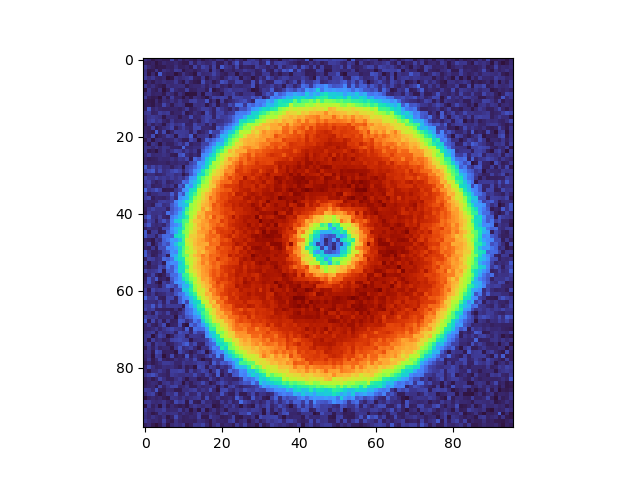

In [26]:
plt.imshow(
    np.fft.fftshift(ctf.compute_ctf(np.angle(recon))),
    vmin=0,vmax=1,
    cmap='turbo',
)
plt.show()